In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import stats

In [2]:
import sys
import importlib
sys.path.append('../ndtest/')
import ndtest
importlib.reload(ndtest);
sys.path.append('../2DKS/')
import KS2D
importlib.reload(KS2D);

In [3]:
# Set parameters
a,b,c = 0.1,1.5,-2.0

In [4]:
# Load data
τ1τ2_direct_full_data = np.loadtxt("../data/%.6f_%.6f_%.6f_jointTruncexpon_direct.dat"%(a,b,c))

In [5]:
# Load data
τ1τ2_rejection_full_data = np.loadtxt("../data/%.6f_%.6f_%.6f_jointTruncexpon_rejection.dat"%(a,b,c))

In [6]:
# Get total number of samples in data
num_samples_data = τ1τ2_rejection_full_data.shape[0]
print("There are a total of %d samples in the full data set."%num_samples_data)

There are a total of 1000000 samples in the full data set.


In [7]:
# Set start index (i.e, how many samples will be thrownaway due to equilibration)
equil_percent = 0.2
start = int(num_samples_data*equil_percent)

print("The %d first samples will be thrown away for equilibration."%start)

The 200000 first samples will be thrown away for equilibration.


In [8]:
τ1_direct_full_data = τ1τ2_direct_full_data[start:,0]
τ2_direct_full_data = τ1τ2_direct_full_data[start:,1]

τ1_rejection_full_data = τ1τ2_rejection_full_data[start:,0]
τ2_rejection_full_data = τ1τ2_rejection_full_data[start:,1]

### $\tau_1$ & $\tau_2$ sampling

In [9]:
def P_marg(x1,a,b,c):
    Z = (np.exp(c*(b-a))-1)/c - (b-a)
    return (np.exp(c*(b-x1))-1)/Z

In [10]:
x1 = np.linspace(a,b,1000)

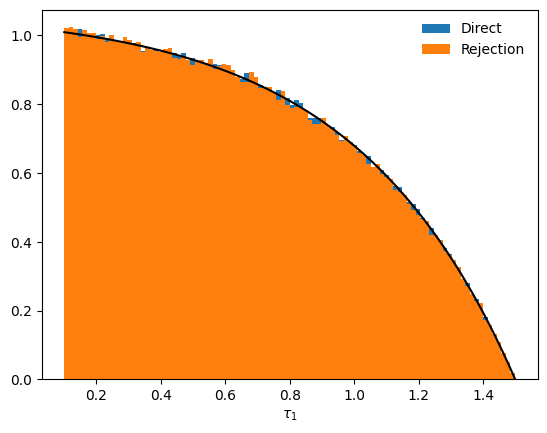

In [11]:
plt.hist(τ1_direct_full_data, density=True, bins=100,label="Direct");  # density=False would make counts
plt.hist(τ1_rejection_full_data, density=True, bins=100,label="Rejection");  # density=False would make counts
plt.plot(x1,P_marg(x1,a,b,c),color='black')
plt.xlabel(r'$\tau_1$');
plt.legend(frameon=False);

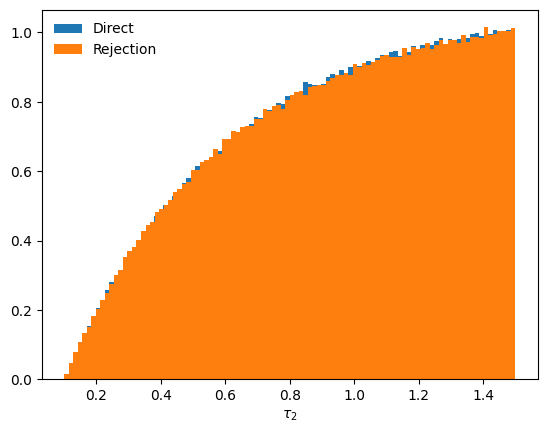

In [12]:
plt.hist(τ2_direct_full_data, density=True, bins=100,label='Direct');  # density=False would make counts
plt.hist(τ2_rejection_full_data, density=True, bins=100,label='Rejection');  # density=False would make counts
plt.xlabel(r'$\tau_2$');
plt.legend(frameon=False);

### $\tau_1 | \tau_2$ heatmap

In [13]:
num_bins = 30

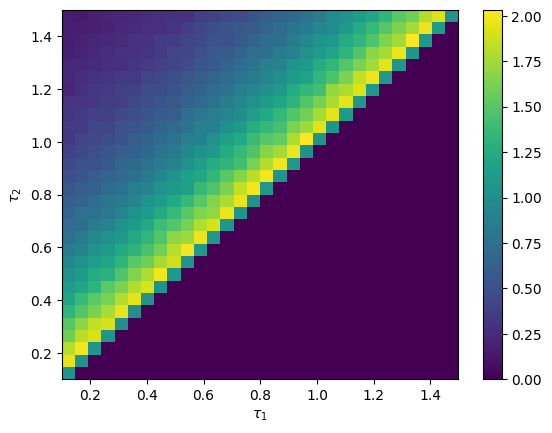

In [14]:
# fig,ax = plt.subplots(1,2,figsize=(10,4.5), dpi=100,sharey=True,tight_layout=True);
fig,ax = plt.subplots()
# plt.subplots_adjust(wspace=0.02);

h = ax.hist2d(τ1_direct_full_data,τ2_direct_full_data,density=True,bins=num_bins)
ax.set_xlabel(r"$\tau_1$")
ax.set_ylabel(r"$\tau_2$");
fig.colorbar(h[3], ax=ax)
# plt.savefig("../figures/joint_truncexpon_histogram_benchmark.pdf",dpi=300)

In [15]:
def _W(τ1,τ2,a,b,c):
    Z = (np.exp(c*(b-a))+a*c-b*c-1)/c**2
    if (τ2<τ1): 
        return 0
    else:
        return np.exp(c*(τ2-τ1))/Z

# Vectorize function so it's "numpy aware"
W = np.vectorize(_W)

def _W_for_ks(τ1,τ2):
    a,b,c = 0.1,1.5,-2.0
    Z = (np.exp(c*(b-a))+a*c-b*c-1)/c**2
    if (τ2<τ1): 
        return 0
    else:
        return np.exp(c*(τ2-τ1))/Z

### Compute exact 2D Distribution

In [16]:
_τ1,_τ2 = np.linspace(a,b,num_bins),np.linspace(a,b,num_bins)

# Create meshgrid
τ1,τ2 = np.meshgrid(_τ1,_τ2)

In [17]:
W = W(τ1,τ2,a,b,c);

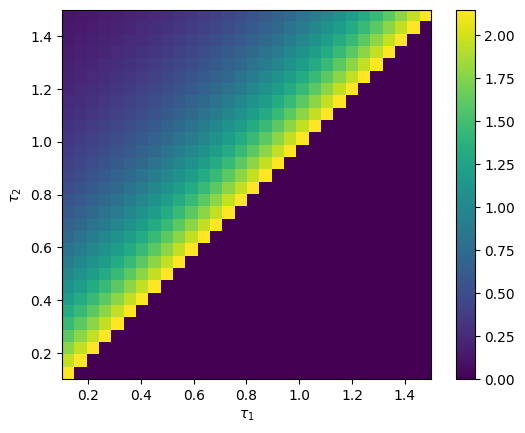

In [18]:
# Plot
plt.imshow(W,origin='lower',extent=[a,b,a,b]);
plt.xlabel(r'$\tau_1$')
plt.ylabel(r'$\tau_2$')
plt.colorbar();

### Compute relative errors

In [19]:
x_bins = np.linspace(a,b,num_bins+1)
y_bins = np.linspace(a,b,num_bins+1)
H = np.histogram2d(τ1_direct_full_data, τ2_direct_full_data, bins=(x_bins, y_bins),density=True) # H as in histogram
H = H[0].T # Why do we need to take transpose?
relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);
relErr_direct = np.ma.masked_array(relErr,mask=relErr==np.diag(relErr))

/tmp/ipykernel_19116/2745573998.py:5: RuntimeWarning: invalid value encountered in divide
  relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);


In [20]:
x_bins = np.linspace(a,b,num_bins+1)
y_bins = np.linspace(a,b,num_bins+1)
H = np.histogram2d(τ1_rejection_full_data, τ2_rejection_full_data, bins=(x_bins, y_bins),density=True) # H as in histogram
H = H[0].T # Why do we need to take transpose?
relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);
relErr_rejection = np.ma.masked_array(relErr,mask=relErr==np.diag(relErr))

/tmp/ipykernel_19116/2401180827.py:5: RuntimeWarning: invalid value encountered in divide
  relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);


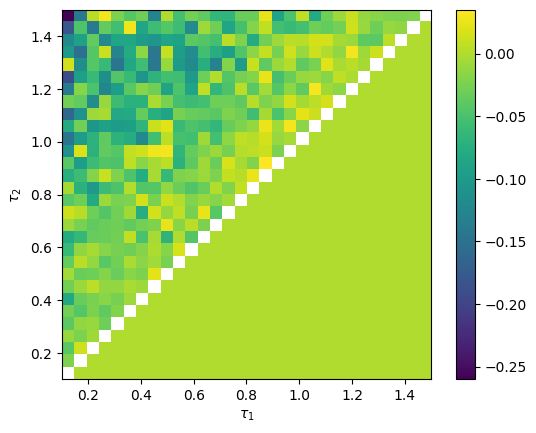

In [21]:
relErr = np.ma.masked_array(relErr,mask=relErr==np.diag(relErr))
plt.imshow((relErr),origin='lower',extent=[a,b,a,b]);
plt.xlabel(r'$\tau_1$')
plt.ylabel(r'$\tau_2$')
plt.colorbar();
# plt.title(r'$c<0$');
# plt.savefig("0.100000_1.300000_-0.500000_relativeError_masked_noAbs.pdf",dpi=400)

## Make combined plot

In [22]:
# Get maximum and minimum values from the exact joint distribution P(τ1,τ2)
vmax = np.max(W)
vmin = np.min(W)

In [23]:
rel_err_vmax_rejection = np.max(relErr_rejection)
rel_err_vmin_rejection = np.min(relErr_rejection)

In [24]:
rel_err_vmax_direct = np.max(relErr_direct)
rel_err_vmin_direct = np.min(relErr_direct)

In [25]:
vmax_rel_err = max(rel_err_vmax_rejection,rel_err_vmax_direct)
vmin_rel_err = min(rel_err_vmin_rejection,rel_err_vmin_direct)

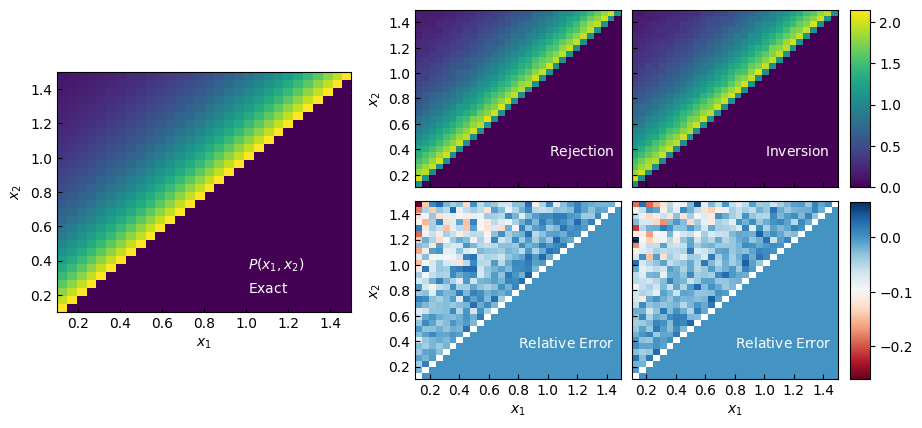

In [233]:
fig9 = plt.figure(constrained_layout=False)

gs1 = fig9.add_gridspec(nrows=1, ncols=1, left=0.00, right=0.46, bottom=0.25, top=0.75,
                        hspace=0.5,wspace=0.05)
f9_ax1 = fig9.add_subplot(gs1[0,0])

gs2 = fig9.add_gridspec(nrows=2, ncols=2, left=0.6-0.04, right=1.26-0.04,
                        hspace=0.08,wspace=0.05)
f9_ax2 = fig9.add_subplot(gs2[0,0],sharey=f9_ax1,sharex=f9_ax1)
f9_ax3 = fig9.add_subplot(gs2[0,1],sharey=f9_ax1,sharex=f9_ax1)

f9_ax4 = fig9.add_subplot(gs2[1,0],sharey=f9_ax1,sharex=f9_ax1)
f9_ax5 = fig9.add_subplot(gs2[1,1],sharey=f9_ax1,sharex=f9_ax1)

# Exact
im = f9_ax1.imshow(W,origin='lower',extent=[a,b,a,b], aspect="auto",vmax=vmax,vmin=vmin)
f9_ax1.set_xlabel(r"$x_1$")
f9_ax1.set_ylabel(r"$x_2$");
f9_ax1.tick_params(axis="both",direction="in")
f9_ax1.annotate(r"$P(x_1,x_2)$",(0.70-0.05,0.18),xycoords="axes fraction",color="white")
f9_ax1.annotate(r"$\rm{Exact}$",(0.70-0.05,0.08),xycoords="axes fraction",color="white")
# fig.colorbar(im, ax=f9_ax1)

# Rejection
h_rejection =f9_ax2.hist2d(τ1_rejection_full_data,τ2_rejection_full_data,density=True,bins=num_bins,vmax=vmax,vmin=vmin)
# f9_ax2.set_xlabel(r"$x_1$")
f9_ax2.set_ylabel(r"$x_2$");
f9_ax2.tick_params(axis="both",direction="in")
f9_ax2.annotate(r"$\rm{Rejection}$",(0.70-0.05,0.18),xycoords="axes fraction",color="white")
f9_ax2.tick_params(labelbottom=False)    
# f9_ax2.axes.xaxis.set_ticklabels([])
# fig.colorbar(h_rejection[3], ax=f9_ax2)
# fig.colorbar(h_rejection[3], ax=f9_ax2).remove()

# Exact/Rejection Relative Error
im2 = f9_ax4.imshow(relErr_rejection,origin='lower',extent=[a,b,a,b], aspect="auto",cmap="RdBu",vmax=vmax_rel_err,vmin=vmin_rel_err);
f9_ax4.set_xlabel(r"$x_1$")
f9_ax4.set_ylabel(r"$x_2$");
f9_ax4.tick_params(axis="both",direction="in")
f9_ax4.annotate(r"$\rm{Relative}\;\rm{Error}$",(0.55-0.05,0.18),xycoords="axes fraction",color="white")
# fig.colorbar(im2, ax=f9_ax4)
# fig.colorbar(im2, ax=f9_ax4).remove()

# Inversion
h = f9_ax3.hist2d(τ1_direct_full_data,τ2_direct_full_data,density=True,bins=num_bins,vmax=vmax,vmin=vmin)
f9_ax3.tick_params(axis="both",direction="in")
f9_ax3.annotate(r"$\rm{Inversion}$",(0.70-0.05,0.18),xycoords="axes fraction",color="white")
f9_ax3.tick_params(labelbottom=False)    
f9_ax3.tick_params(labelleft=False)    
# f9_ax3.axes.xaxis.set_ticklabels([])
# f9_ax3.axes.yaxis.set_ticklabels([])
# fig9.colorbar(h[3], ax=f9_ax3)
# fig9.colorbar(h[3], ax=f9_ax3).remove()

# Exact/Inversion Relative Error
im2 = f9_ax5.imshow(relErr_direct,origin='lower',extent=[a,b,a,b], aspect="auto",cmap="RdBu",vmax=vmax_rel_err,vmin=vmin_rel_err);
f9_ax5.set_xlabel(r"$x_1$")
f9_ax5.tick_params(axis="both",direction="in")
f9_ax5.annotate(r"$\rm{Relative}\;\rm{Error}$",(0.55-0.05,0.18),xycoords="axes fraction",color="white")
f9_ax5.tick_params(labelleft=False)    
# f9_ax5.axes.yaxis.set_ticklabels([])
# fig9.colorbar(im2, ax=f9_ax5)
# fig9.colorbar(im2, ax=f9_ax5).remove()

# add colorbars
cbaxes_1 = fig9.add_axes([1.24, 0.51, 0.03, 0.37]) 
cbaxes_2 = fig9.add_axes([1.24, 0.11, 0.03, 0.37]) 

# position for the colorbar
cb_1 = plt.colorbar(im, cax = cbaxes_1)
cb_2 = plt.colorbar(im2, cax = cbaxes_2)

f9_ax1.tick_params(axis="both",direction="in")
f9_ax2.tick_params(axis="both",direction="in")
f9_ax3.tick_params(axis="both",direction="in")
f9_ax4.tick_params(axis="both",direction="in")
f9_ax5.tick_params(axis="both",direction="in")

fig9.savefig("../figures/joint_truncexpon_histogram_benchmark.pdf",dpi=300,bbox_inches='tight')

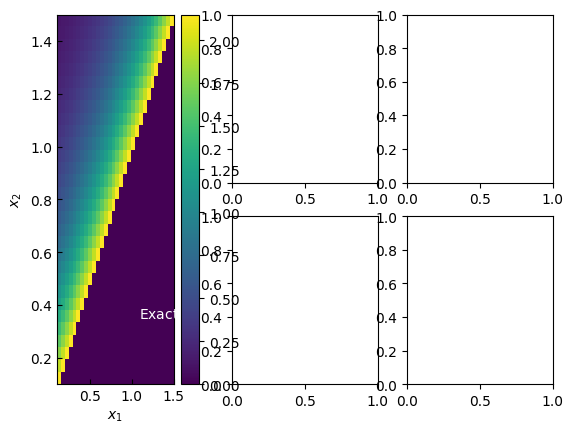

In [40]:
# with plt.style.context('../IOP_large.mplstyle'):

# fig,ax = plt.subplots(2,3,figsize=(10,4.5), dpi=100,sharey=True,sharex=True,tight_layout=True);

fig = plt.figure()

gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[:, 0],)
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2])

# Exact
im = ax1.imshow(W,origin='lower',extent=[a,b,a,b], aspect="auto",vmax=vmax,vmin=vmin)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$");
ax1.tick_params(axis="both",direction="in")
ax1.annotate(r"$\rm{Exact}$",(0.70,0.18),xycoords="axes fraction",color="white")
fig.colorbar(im, ax=ax1)

# # Rejection
# h_rejection = ax2.hist2d(τ1_rejection_full_data,τ2_rejection_full_data,density=True,bins=num_bins,vmax=vmax,vmin=vmin)
# ax2.set_xlabel(r"$x_1$")
# ax2.tick_params(axis="both",direction="in")
# ax2.annotate(r"$\rm{Rejection}$",(0.70,0.18),xycoords="axes fraction",color="white")
# fig.colorbar(h_rejection[3], ax=ax2)

# # Exact/Rejection Relative Error
# im2 = ax4.imshow(relErr_rejection,origin='lower',extent=[a,b,a,b], aspect="auto",cmap="RdBu",vmax=vmax_rel_err,vmin=vmin_rel_err);
# ax4.set_xlabel(r"$x_1$")
# ax4.tick_params(axis="both",direction="in")
# ax4.annotate(r"$\rm{Relative}\;\rm{Error}$",(0.55,0.18),xycoords="axes fraction",color="white")
# fig.colorbar(im2, ax=ax4)

# # # Exact
# # im = ax[1,0].imshow(W,origin='lower',extent=[a,b,a,b], aspect="auto",vmax=vmax,vmin=vmin)
# # ax[1,0].set_ylabel(r"$x_2$");
# # ax[1,0].tick_params(axis="both",direction="in")
# # ax[1,0].annotate(r"$\rm{Exact}$",(0.70,0.18),xycoords="axes fraction",color="white")
# # fig.colorbar(im, ax=ax[1,0])

# # Inversion
# h = ax3.hist2d(τ1_direct_full_data,τ2_direct_full_data,density=True,bins=num_bins,vmax=vmax,vmin=vmin)
# ax3.tick_params(axis="both",direction="in")
# ax3.annotate(r"$\rm{Inversion}$",(0.70,0.18),xycoords="axes fraction",color="white")
# fig.colorbar(h[3], ax=ax3)

# # Exact/Inversion Relative Error
# im2 = ax5.imshow(relErr_direct,origin='lower',extent=[a,b,a,b], aspect="auto",cmap="RdBu",vmax=vmax_rel_err,vmin=vmin_rel_err);
# ax5.tick_params(axis="both",direction="in")
# ax5.annotate(r"$\rm{Relative}\;\rm{Error}$",(0.55,0.18),xycoords="axes fraction",color="white")
# fig.colorbar(im2, ax=ax5)

# plt.savefig("../figures/joint_truncexpon_histogram_benchmark.pdf",dpi=300)

In [28]:
# Check normalization
# integrate.quad(W,τ1_direct_full_data,τ2_direct_full_data,a,b,c)

In [29]:
τ1τ2_direct=np.array(list(zip(τ1_direct_full_data,τ2_direct_full_data)))

In [46]:
τ1τ2_rejection=np.array(list(zip(τ1_rejection_full_data,τ2_rejection_full_data)))

In [81]:
# Compute kstest as a function of sample number
num_samples_rejection = 50
num_samples_direct = 50

In [82]:
pvalues_rejection = np.zeros(num_samples_rejection)
pvalues_direct = np.zeros(num_samples_direct)

In [83]:
ksvalues_rejection = np.zeros(num_samples_rejection)
ksvalues_direct = np.zeros(num_samples_direct)

In [84]:
%%time
for i in range(num_samples_rejection):
    if i%10000==0: print("%d/%d"%(i,num_samples_rejection))
    
    ksvalues_rejection[i],pvalues_rejection[i] = KS2D.ks2d1s(τ1τ2_rejection[:i+2],_W_for_ks)

    ksvalues_direct[i],pvalues_direct[i] = KS2D.ks2d1s(τ1τ2_direct[:i+2],_W_for_ks)
    

0/50
(2, 2)


/usr/local/lib/python3.8/dist-packages/scipy/integrate/quadpack.py:864: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(2, 2)


/usr/local/lib/python3.8/dist-packages/scipy/integrate/quadpack.py:864: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(3, 2)
(3, 2)


/usr/local/lib/python3.8/dist-packages/scipy/integrate/quadpack.py:864: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(4, 2)
(4, 2)
(5, 2)
(5, 2)
(6, 2)
(6, 2)
(7, 2)
(7, 2)
(8, 2)
(8, 2)
(9, 2)
(9, 2)
(10, 2)
(10, 2)
(11, 2)
(11, 2)
(12, 2)
(12, 2)
(13, 2)
(13, 2)
(14, 2)
(14, 2)
(15, 2)
(15, 2)
(16, 2)
(16, 2)
(17, 2)
(17, 2)
(18, 2)
(18, 2)
(19, 2)
(19, 2)
(20, 2)
(20, 2)
(21, 2)
(21, 2)
(22, 2)
(22, 2)
(23, 2)
(23, 2)
(24, 2)
(24, 2)
(25, 2)
(25, 2)
(26, 2)
(26, 2)
(27, 2)
(27, 2)
(28, 2)
(28, 2)
(29, 2)
(29, 2)
(30, 2)
(30, 2)
(31, 2)
(31, 2)
(32, 2)
(32, 2)
(33, 2)
(33, 2)
(34, 2)
(34, 2)
(35, 2)
(35, 2)
(36, 2)
(36, 2)
(37, 2)
(37, 2)
(38, 2)
(38, 2)
(39, 2)
(39, 2)
(40, 2)
(40, 2)
(41, 2)
(41, 2)
(42, 2)
(42, 2)
(43, 2)
(43, 2)
(44, 2)
(44, 2)
(45, 2)
(45, 2)
(46, 2)
(46, 2)
(47, 2)
(47, 2)
(48, 2)
(48, 2)
(49, 2)
(49, 2)
(50, 2)
(50, 2)
(51, 2)
(51, 2)
CPU times: user 3h 19min 39s, sys: 5.54 s, total: 3h 19min 45s
Wall time: 3h 19min 52s


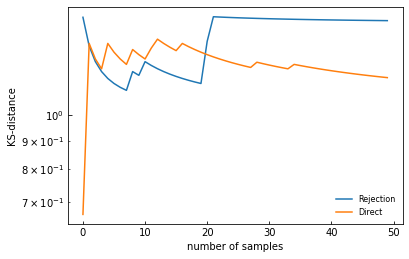

In [85]:
# with plt.style.context('../IOP_large.mplstyle2'):
#     fig,ax = plt.subplots(2,1,figsize=(4.5,4.5), dpi=150,sharey=False,sharex=False,tight_layout=False);
fig,ax = plt.subplots()
#     plt.subplots_adjust(wspace=0.02);
#     plt.subplots_adjust(hspace=0.02);

# ax.set_xscale("log")
ax.set_yscale("log")

ax.plot(range(num_samples_rejection),ksvalues_rejection,label='Rejection')
ax.plot(range(num_samples_direct),ksvalues_direct,label='Direct')
ax.axhline(0.0,color="#aaaaaa",zorder=-10)
ax.set_ylabel("KS-distance")
ax.tick_params(direction='in',which='both')
# ax.set_xlim(-2000,100000)
ax.set_xlabel("number of samples")

#     ax[1].plot(range(num_samples_rejection),pvalues_rejection,label='Rejection')
#     ax[1].plot(range(num_samples_direct),pvalues_direct,label='Direct')
#     ax[1].axhline(1.0,color="#aaaaaa",zorder=-10)
#     ax[1].set_ylabel("p-value")
#     ax[1].tick_params(direction='in')

ax.legend(frameon=False,fontsize=8)

plt.savefig("../figures/%.6f_%.6f_%.6f_jointTruncexpon_ksTest.pdf"%(a,b,c),dpi=300)